In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skvideo
import skvideo.io
import glob

import skimage
from skimage.color import rgb2gray
from skimage import feature
from skimage.transform import hough_circle, hough_circle_peaks

from scipy.fft import rfft, rfftfreq
from scipy.optimize import curve_fit

import pandas as pd

import h5py

In [2]:
ffmpeg_path = glob.glob("/opt/homebrew/Cellar/ffmpeg/*/bin/")[0]
skvideo.setFFmpegPath(ffmpeg_path)

### 0. Import video

Takes around 20s to run:

In [3]:
nominal_cps = 0.2
fname='UDV-calibration-videos/'+str(nominal_cps).replace(".","_")+'-cps.MOV'
fname='UDV-calibration-videos/0_2-cps.MOV'
videodata_full = skvideo.io.vread(fname)
metadata = skvideo.io.ffprobe(fname)

Crop video

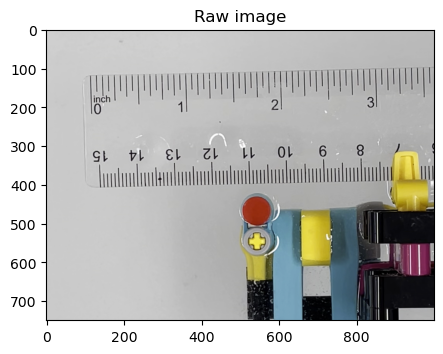

In [4]:
videodata = videodata_full[:,500:1250,0:1000,:]
plt.figure(figsize=(5,5))
plt.imshow(videodata[0,...])
plt.title("Raw image")
plt.savefig("figures/raw-image.png",dpi=300)
plt.show()

Get framerate

In [5]:
# Helper function for reading framerate from video metadata
# convert fraction strings to float (credit: https://stackoverflow.com/a/19073403)

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        try:
            num, denom = frac_str.split('/')
        except ValueError:
            return None
        try:
            leading, num = num.split(' ')
        except ValueError:
            return float(num) / float(denom)        
        if float(leading) < 0:
            sign_mult = -1
        else:
            sign_mult = 1
        return float(leading) + sign_mult * (float(num) / float(denom))

In [6]:
framerate = convert_to_float(metadata['video']['@avg_frame_rate']) # fps

### 1. Tune parameters on first frame

In [7]:
frame_ind = 0
frame0 = videodata[frame_ind,...]

#### Pick points to set scale:

scale = 96.3 pixels/cm


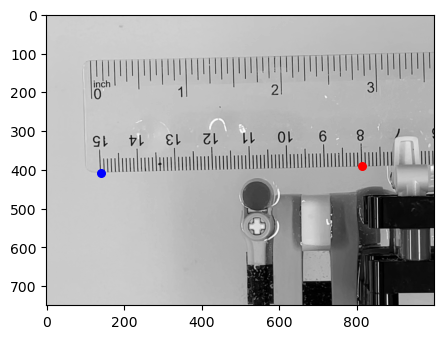

In [8]:
# Manually adjust values of p1, p2, dist_cm

p1 = (814,391) # pixel coordinates
p2 = (140,407) # pixel coordinates
dist_cm = 15 - 8 # cm

dist_pix = np.sqrt(np.sum([(p1[i]-p2[i])**2 for i in range(2)]))
pix_per_cm = dist_pix/dist_cm

print(f"scale = {pix_per_cm:.1f} pixels/cm")

plt.figure(figsize=(5,5))
plt.imshow(rgb2gray(frame0),cmap='binary_r')
plt.scatter(*p1,color='r',s=30)
plt.scatter(*p2,color='b',s=30)
plt.show()

#### Get red disk center 

Mask out everything but the red disk, and get the disk edge.

In [9]:
def get_edges(frame, rg_ratio, rb_ratio, lum_low, lum_hi):
    red_mask = (frame[:,:,0]>rg_ratio*frame[:,:,1])&(frame[:,:,0]>rb_ratio*frame[:,:,2])

    masked_frame = rgb2gray(frame)
    masked_frame[~red_mask] = 0
    thresh = (masked_frame>lum_low)&(masked_frame<lum_hi)
    masked_frame[~thresh]=0
    masked_frame[thresh]=1

    edges = feature.canny(masked_frame,sigma=10)

    return edges,masked_frame

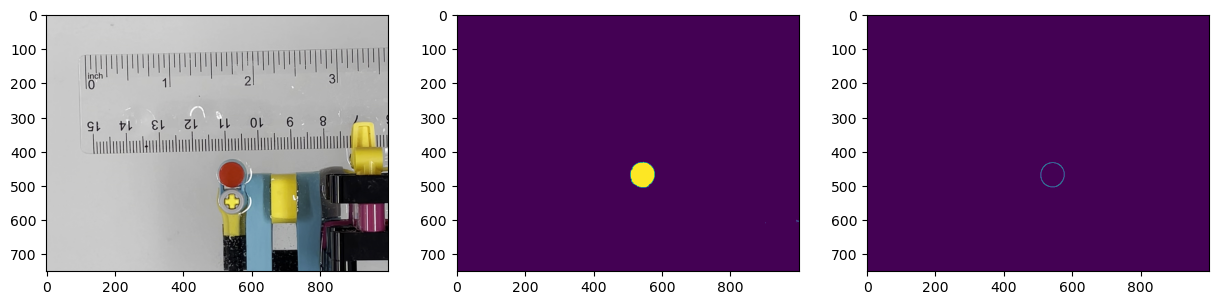

In [10]:
rg_ratio, rb_ratio, lum_low, lum_hi = [1.7, 2.0, 0.1, 0.8]
edges0,masked_frame0 = get_edges(frame0, rg_ratio, rb_ratio, lum_low, lum_hi)

fig,axs=plt.subplots(1,3,figsize=(15,4))
axs[0].imshow(frame0)
axs[1].imshow(masked_frame0)
axs[2].imshow(edges0)
plt.show()

Get the disk center position using the Hough transform

In [11]:
# Input measured diameter of red disk (e.g. using a ruler or calipers)
disk_diam_cm = 0.777 # cm

disk_diam_pix = disk_diam_cm * pix_per_cm

In [12]:
def get_disk_center(edges,disk_diam_pix):
    hough_radii = np.linspace(0.9*disk_diam_pix/2,1.1*disk_diam_pix/2,50)
    hough_res = hough_circle(edges, hough_radii)
    accums, xc, yc, r = hough_circle_peaks(hough_res, hough_radii,total_num_peaks=1)
    if len(xc)==0:
        xc = np.nan
    else:
        xc = xc[0]
    if len(yc)==0:
        yc = np.nan
    else:
        yc = yc[0]
    if len(r)==0:
        r = np.nan
    else:
        r = r[0]
    
    return xc, yc, r

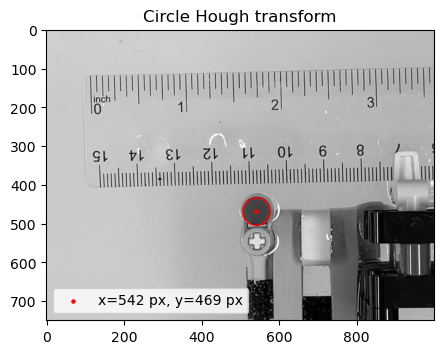

In [13]:
xc0, yc0, r0 = get_disk_center(edges0,disk_diam_pix)

fig,axs=plt.subplots(1,1,figsize=(5,5))
axs.imshow(rgb2gray(frame0),cmap="binary_r")
circ = plt.Circle((xc0,yc0),r0,fill=False,ec='r')
axs.add_artist(circ)
axs.scatter(xc0-0.5,yc0-0.5,marker=".",color="r",s=20, label=f"x={xc0:.0f} px, y={yc0:.0f} px")
axs.legend(loc="lower left")
axs.set_title("Circle Hough transform")
plt.savefig("figures/hough-trans.png",dpi=300)
plt.show()

**Summary:**

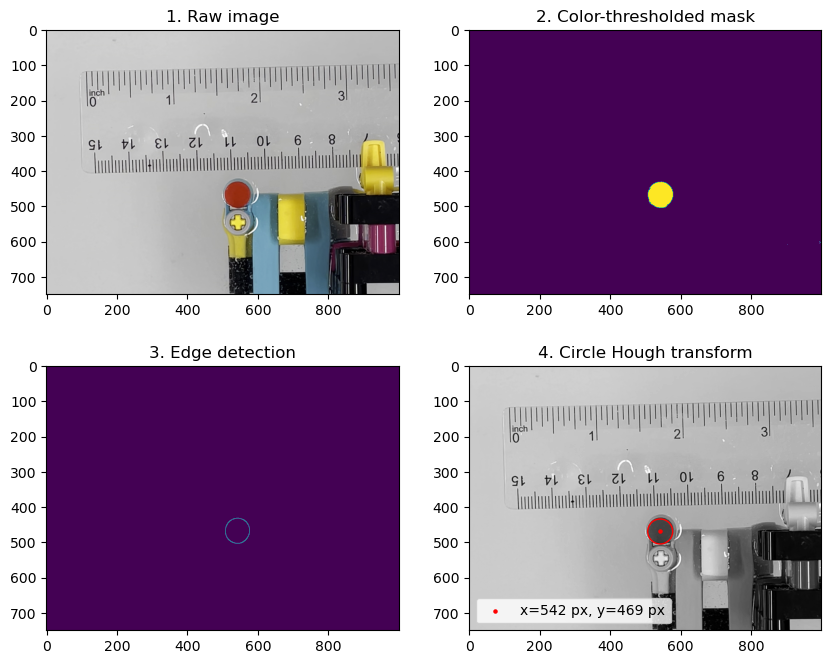

In [14]:
fig,axs=plt.subplots(2,2,figsize=(10,8))
axs[0,0].imshow(frame0)
axs[0,0].set_title("1. Raw image")
axs[0,1].imshow(masked_frame0)
axs[0,1].set_title("2. Color-thresholded mask")
axs[1,0].imshow(edges0)
axs[1,0].set_title("3. Edge detection")
axs[1,1].imshow(rgb2gray(frame0),cmap="binary_r")
circ = plt.Circle((xc0,yc0),r0,fill=False,ec='r')
axs[1,1].add_artist(circ)
axs[1,1].scatter(xc0-0.5,yc0-0.5,marker=".",color="r",s=20, label=f"x={xc0:.0f} px, y={yc0:.0f} px")
axs[1,1].set_title("4. Circle Hough transform")
axs[1,1].legend(loc="lower left")
plt.savefig("figures/image-pipeline-summary.png",dpi=600)
plt.show()

### 2. Repeat on all frames

In [15]:
stride = 1

N_tot = videodata.shape[0]
frame_inds = np.arange(0,N_tot,stride)
t_arr = frame_inds/framerate
x_arr = np.zeros(len(frame_inds))
y_arr = np.zeros(len(frame_inds))

for i in np.arange(len(frame_inds)):
    frame = videodata[frame_inds[i],...]
    edges, masked_frame = get_edges(frame, rg_ratio, rb_ratio, lum_low, lum_hi)
    xc, yc, r = get_disk_center(edges,disk_diam_pix)
    x_arr[i] = xc
    y_arr[i] = yc

### 3. Get displacement time series and process

Convert positions to displacement and replace outliers with nan

In [16]:
start_ind = 40
end_ind = -50

x_arr_clean = np.nan_to_num(x_arr)[start_ind:end_ind]
y_arr_clean = np.nan_to_num(y_arr)[start_ind:end_ind]
t_arr_clean = t_arr[start_ind:end_ind]

In [17]:
x0 = np.max(x_arr[~np.isnan(x_arr)][start_ind:end_ind])
y0 = np.max(y_arr[~np.isnan(y_arr)][start_ind:end_ind])

l_cm = (np.sqrt((x_arr_clean - x0)**2 + (y_arr_clean - y0)**2))/pix_per_cm

zscore = (l_cm - np.mean(l_cm))/np.std(l_cm)

l_cm_w_nans = np.copy(l_cm)
l_cm_w_nans[zscore>4]=np.nan

Use FFT to obtain initial parameter value guesses for fitting a sinusoidal function

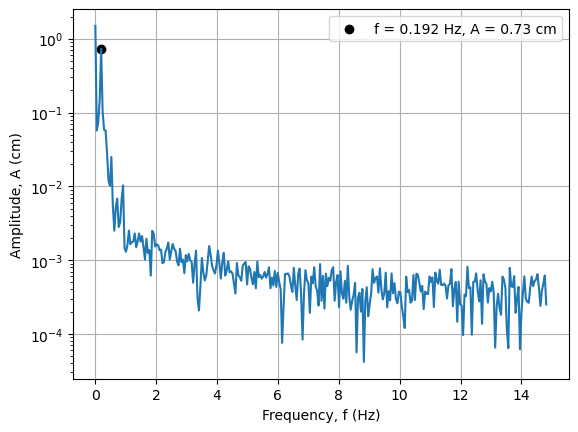

In [18]:
N = len(l_cm)
amplarr = np.abs(rfft(l_cm))/(N/2)
freqarr = rfftfreq(N, d=np.diff(t_arr)[0])
amp = np.max(amplarr[freqarr>1e-6])
freq = freqarr[amplarr==amp][0]

plt.semilogy(freqarr,amplarr)
plt.scatter(freq,amp,color="k",label=f"f = {freq:.3f} Hz, A = {amp:.2f} cm")
plt.legend()
plt.xlabel("Frequency, f (Hz)")
plt.ylabel("Amplitude, A (cm)")
plt.grid()

Before fitting, trim data to include a whole number of cycles

In [19]:
Ncycles = np.floor((t_arr_clean[-1]-t_arr_clean[0])*freq)
tfinal = t_arr_clean[0]+Ncycles/freq
t_arr_trim = t_arr_clean[t_arr_clean<=tfinal]
l_cm_trim = l_cm_w_nans[t_arr_clean<=tfinal]
l_cm_trim = (l_cm_trim - np.mean(l_cm_trim))

Fit a sinusoidal function to the data

In [20]:
def sinusoid(t,A,f,phase):
    return A*np.sin(2*np.pi*f*t + phase)

In [21]:
p0 = np.array([amp,freq,np.pi])
popt, pcov = curve_fit(sinusoid, t_arr_trim, l_cm_trim,p0=p0)
l_cm_fit = sinusoid(t_arr_trim,*popt)

Also smooth the raw data with a moving average

In [22]:
window_size = 10
l_cm_trim_series = pd.Series(l_cm_trim)
l_cm_smooth = l_cm_trim_series.rolling(window_size,min_periods=int(window_size/2),center=True).mean().to_numpy()

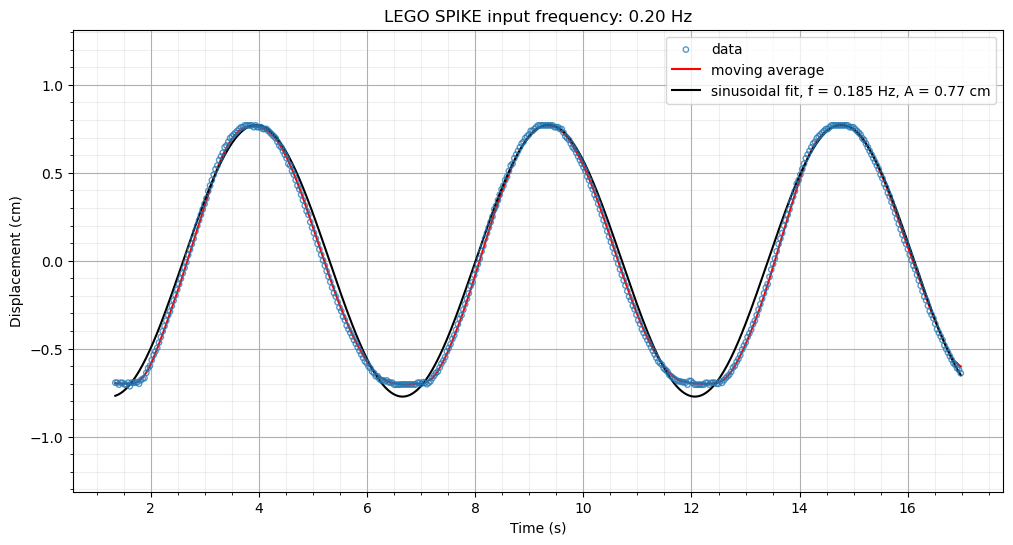

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(t_arr_trim,l_cm_trim,s=15,zorder=10,label="data",facecolors='none',edgecolors='tab:blue',alpha=0.75)
plt.plot(t_arr_trim,l_cm_smooth,"r",label="moving average")
plt.plot(t_arr_trim,l_cm_fit,"k",label=f"sinusoidal fit, f = {popt[1]:.3f} Hz, A = {popt[0]:.2f} cm")
plt.legend(loc="upper right")
plt.ylim(-1.7*np.abs(popt[0]),1.7*np.abs(popt[0]))
plt.xlabel("Time (s)")
plt.ylabel("Displacement (cm)")
plt.title(f"LEGO SPIKE input frequency: {nominal_cps:.2f} Hz")
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor',alpha=0.2)
plt.savefig(f"figures/displacement-{nominal_cps:.1f}-Hz.jpg",dpi=500)

### 4. Get velocity

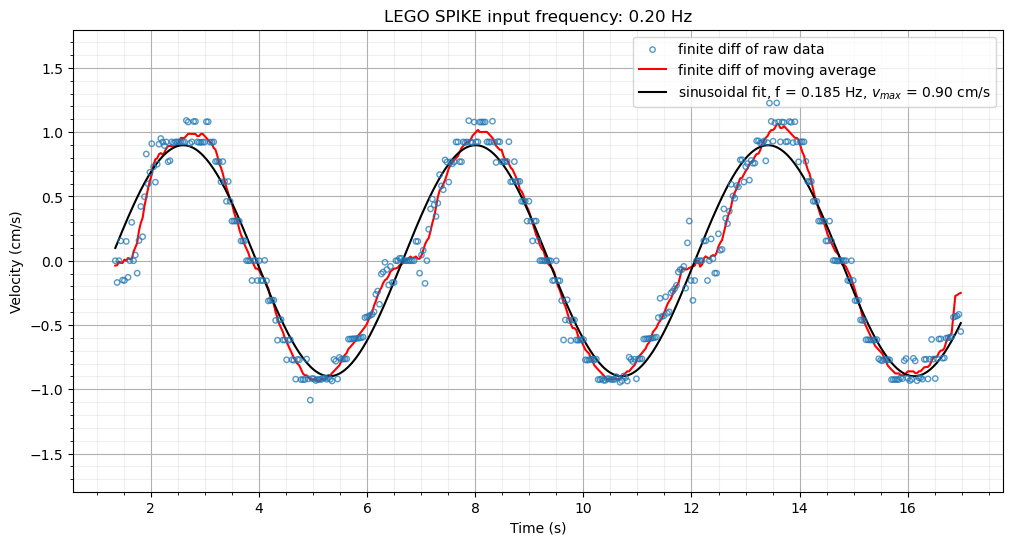

In [24]:
v_arr_trim = np.gradient(l_cm_trim,t_arr_trim)
v_max_sin = popt[0]*2*np.pi*popt[1]
v_arr_sin = v_max_sin*np.cos(2*np.pi*popt[1]*t_arr_trim + popt[2])

strd = 1
t_arr_smooth = t_arr_trim[::strd]
v_arr_smooth = np.gradient(l_cm_smooth[::strd],t_arr_smooth)


plt.figure(figsize=(12,6))

plt.scatter(t_arr_trim,v_arr_trim,s=15,zorder=10,label="finite diff of raw data",facecolors='none',edgecolors='tab:blue',alpha=0.75)
plt.plot(t_arr_trim,v_arr_smooth,"r",label="finite diff of moving average")
plt.plot(t_arr_trim,v_arr_sin,"k",label=f"sinusoidal fit, f = {popt[1]:.3f} Hz, "+"$v_{max}$"+f" = {v_max_sin:.2f} cm/s")
plt.legend(loc="upper right")
plt.ylim(-2*np.abs(v_max_sin),2*np.abs(v_max_sin))
plt.xlabel("Time (s)")
plt.ylabel("Velocity (cm/s)")
plt.title(f"LEGO SPIKE input frequency: {nominal_cps:.2f} Hz")
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor',alpha=0.2)
plt.savefig(f"figures/velocity-{nominal_cps:.1f}-Hz.jpg",dpi=500)

In [25]:
expfname = 'ground-truth-data/'+str(nominal_cps).replace(".","_")+'-cps-ground-truth.h5'
expData = h5py.File(expfname, 'w')
arrGroup = expData.create_group('tseries')
paramGroup = expData.create_group('fitparams')

arrGroup.create_dataset('t (s)',data=t_arr_trim)
arrGroup.create_dataset('disp, raw (cm)',data=l_cm_trim)
arrGroup.create_dataset('disp, smooth (cm)',data=l_cm_smooth)
arrGroup.create_dataset('v, raw (cm/s)',data=v_arr_trim)
arrGroup.create_dataset('v, smooth (cm/s)',data=v_arr_smooth)

paramGroup.create_dataset('f (Hz)',data=[popt[1]])
paramGroup.create_dataset('disp_max (cm)',data=[popt[0]])
paramGroup.create_dataset('v_max (cm/s)',data=[v_max_sin])
expData.close()